# Import packages

In [1]:
# Get torch modules and others.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
import copy, math, time
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from PIL import Image
import io, os, zipfile, csv
from google.colab import files
from torch.utils.data.sampler import SubsetRandomSampler
import pdb

# Alternate idea

This idea involves using cv2 to find contours around figures in the image, then passing the part of the image with the figure through a normal convolutional network. Once we have the results from all the figures, we pass the tokens and positional data through a seq2seq model and proceed from there. 

In [ ]:
import numpy as np
dataset_size = 67
indices = list(range(dataset_size))
split = int(np.floor(.2 * dataset_size))
print(indices)
print(split)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
13


In [ ]:
class SymbolDataset(Dataset):
  def __init__(self, zip_file='symbols.zip', size=45):
    super(SymbolDataset, self).__init__()

    self.train = train
    extract_dir = os.path.splitext(zip_file)[0]
    if not os.path.exists(extract_dir):
      os.makedirs(extract_dir)
      self.extract_zip(zip_file, extract_dir)
      self.resize(extract_dir, size=size)

    postfix = 'train' if train else 'test'

    self.dataset_folder = datasets.ImageFolder(extract_dir, transform=transforms.Compose([transforms.ToTensor()]))

  def extract_zip(self, zip_file, extract_dir):
    print("Extracting", zip_file)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)

  def __getitem__(self, i):
    return self.dataset_folder[i]

  def __len__(self):
    return len(self.dataset_folder)

In [ ]:
class SingleSymbolNetwork(nn.Module):
  def __init__(self, dataset):
    super(SingleSymbolNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    output = len(dataset.targets)
    
    self.net = nn.Sequential(
        nn.Conv2d(c, 100, (3, 3), padding=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(100, 100, (3, 3), padding=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(100, 100, (3, 3), padding=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(100, output, (45, 45), padding=(0, 0)) # Magic number warning!!
    )

    def forward(self, x):
      return self.net(x).squeeze(2).squeeze(2)

In [ ]:
dataset = SymbolDataset(zip_file="numbers.zip")
model = SingleSymbolNetwork(dataset)
model.cuda()

batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed = 314159

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)




In [ ]:
import IPython.display
import PIL.Image
import cv2
import numpy as np

In [ ]:
def nbimage(data):
    IPython.display.display(PIL.Image.fromarray(data))

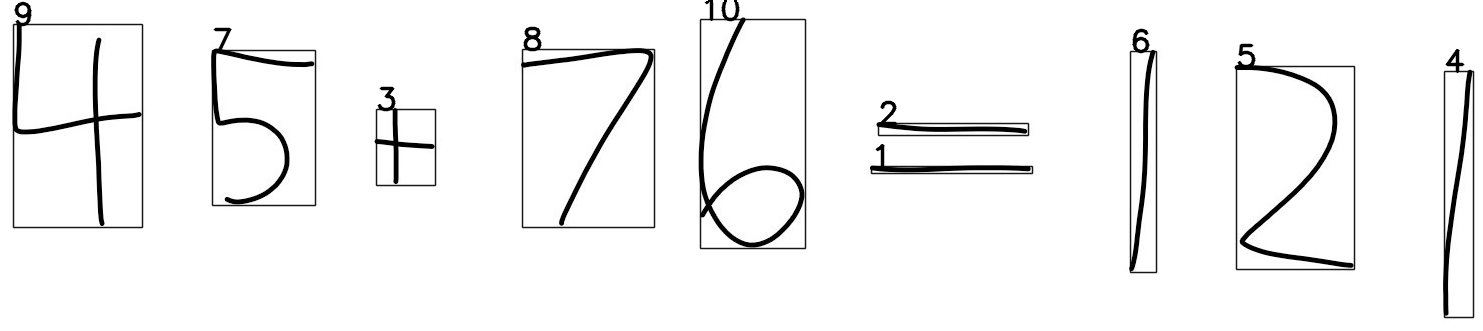

In [ ]:
img = cv2.imread("equation1.jpg")
#img = trim_image(img)
#nbimage(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
m, n = img.shape
xlist = list()
ylist = list()
for x in range(0, m):
  for y in range(0, n):
    if img[x, y] < 255:
      xlist.append(x)
      ylist.append(y)

left = min(xlist)
right = max(xlist)
top = min(ylist)
bottom = max(ylist)
img = img[left-10:right+10, top-10:bottom+10]
#nbimage(img)

ret, thresh = cv2.threshold(img, 100, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
morphed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((2, 2)))

cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
nh, nw = img.shape[:2]
num = 1
for cnt in cnts:
  x, y, w, h = cv2.boundingRect(cnt)
  #if h < 0.3*nh:
  #  continue
  cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), 1, cv2.LINE_AA)
  cv2.putText(img, str(num), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
  num += 1

nbimage(img)

In [ ]:
def trim_image(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = 255*(gray < 128).astype(np.uint8)
  coords = cv2.findNonZero(gray)
  x, y, w, h = cv2.boundingRect(coords)
  print(x, y, w, h)
  return img[y:y+h, x:x+h]

# Test zone

In [ ]:
import pdb

In [ ]:
load = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Grayscale()
])

def upload_image():
  file_dict = files.upload()
  image_path = io.BytesIO(file_dict[next(iter(file_dict))])
  image_orig = Image.open(image_path)
  image = load(np.array(image_orig)).unsqueeze(0)#.cuda()

  return image

test_image = upload_image()

Saving 2468.png to 2468.png


In [ ]:
test_image.size()

torch.Size([1, 1, 72, 192])

In [2]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

In [ ]:
image_label = torch.tensor([[0, 4, 6, 8, 10, 1]])
a.size()

torch.Size([1, 6])

In [ ]:
model = TransformerModel(23)
result = model.forward(test_image, image_label, None, None)
print(result.size())
print(result)

torch.Size([1, 6, 512])
tensor([[[-0.2321, -0.3540,  0.2577,  ..., -0.6877, -0.0990,  0.7072],
         [ 0.0186, -0.4063,  0.9717,  ..., -1.2657,  1.0326,  0.0349],
         [-0.9475,  0.2188,  0.7932,  ..., -0.4707,  0.1658,  0.1043],
         [-1.1108, -0.1735,  0.5287,  ..., -0.3654,  0.3609,  1.1381],
         [-0.9994, -0.7305, -0.7806,  ..., -0.5152, -0.2607,  1.1009],
         [-0.2448,  0.8303, -0.0753,  ..., -0.5195, -0.6192, -0.1775]]],
       grad_fn=<AddBackward0>)


# Dataset preparation

## Dataset

In [3]:
class EquationDataset(Dataset):
  def __init__(self, zip_file, formula_file, index_file, transform, file_ext=".jpg"):
    super(Dataset, self).__init__()
    self.file_ext = file_ext

    extract_dir = os.path.splitext(zip_file)[0]
    if not os.path.exists(extract_dir):
      os.makedirs(extract_dir)
      self.extract_zip(zip_file, extract_dir)

    self.formula_dir = os.path.join(extract_dir, extract_dir)
    #self.total_imgs = os.listdir(self.formula_dir)

    self.transform = transform
    self.max_formula_size = 0

    with open(formula_file, 'r') as file:
      self.formulas = file.read().splitlines()
      for formula in self.formulas:
        if len(formula.split(" ")) > self.max_formula_size:
          self.max_formula_size = len(formula.split(" "))

    self.image2index = dict()
    with open(index_file) as file:
      reader = csv.reader(file, delimiter=" ")
      for row in reader:
        self.image2index[row[1]] = row[0]

    self.image_list = list(self.image2index.keys())

  def extract_zip(self, zip_file, extract_dir):
    print("Extracting", zip_file)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
      zip_ref.extractall(extract_dir)

  def __len__(self):
    return len(self.image_list)

  def __getitem__(self, i):
    img_loc = os.path.join(self.formula_dir, self.image_list[i] + self.file_ext)
    image = Image.open(img_loc)
    image = self.transform(np.array(image))#.cuda()
    image_formula = self.formulas[int(self.image2index[self.image_list[i]])]
    image_tensor = parser.string2tensor(image_formula)

    src_mask = torch.tensor([0]) # Maybe do something with this later

    # Probably move the operations below into the Dataloader in the future. For now, we'll leave this here. 
    trg = torch.cat((torch.tensor([parser.SOS]), image_tensor, torch.tensor([parser.EOS]), torch.zeros(self.max_formula_size - image_tensor.size()[0])))
    trg_y = trg[1:].long() # All the inputs shifted over
    trg = trg[:-1].long() # Kick off the ending in the original

    trg_mask = make_trg_mask(trg, parser.pad)

    return image, src_mask, trg, trg_y, trg_mask

def subsequent_mask(size):
  "Mask out subsequent positions"
  attn_shape = (size, size)
  subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  return torch.from_numpy(subsequent_mask) == 0

def make_trg_mask(tgt, pad):
  tgt_mask = (tgt != pad).unsqueeze(-2)
  tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
  return tgt_mask

In [ ]:
trg = torch.tensor([1, 4, 6, 3, 7])
make_trg_mask(trg, 0)

tensor([[ True, False, False, False, False],
        [ True,  True, False, False, False],
        [ True,  True,  True, False, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True]])

In [ ]:
train_dataset = EquationDataset("he2latex_formulas.zip", "formulas.txt", "train.txt", transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Grayscale()
]))

In [ ]:
print(train_dataset[1][2])
print(train_dataset[1][3])
print(train_dataset[1][4])

## Dataloader

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, num_workers=0, batch_size=4)

In [ ]:
for src, src_mask, trg, trg_y, trg_mask in train_loader:
  print(src.size())
  print(src_mask.size())
  print(trg.size())
  print(trg_y.size())
  print(trg_mask.size())

# Setup

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time

In [ ]:
# For testing purposes

In [4]:
pad_token = 0
SOS_token = 1
EOS_token = 2
simple_tokens = r"0 1 2 3 4 5 6 7 8 9 - + = ^ \frac \leq \neq \geq \alpha \beta \lambda < > x y { }"

class Tokens:
  """This is a class to hold tokens and references to them."""
  def __init__(self, name, token_str, sep=' '):
    """Takes a name and some tokens and then splits them into a dictionaries to map things."""
    tokens = ("BLANK SOS EOS " + token_str).split(sep)
    num_tokens = len(tokens)
    self.name = name
    self.word2index = dict(zip(tokens, range(num_tokens)))
    self.index2word = dict(zip(range(num_tokens), tokens))
    self.SOS = SOS_token
    self.EOS = EOS_token
    self.pad = pad_token
    self.num_tokens = num_tokens

  def string2tensor(self, latex_str):
    return torch.tensor([self.word2index[i] for i in latex_str.split(" ")])

In [5]:
parser = Tokens("test_dataset", simple_tokens)
print(parser.word2index)
print(parser.index2word)

{'BLANK': 0, 'SOS': 1, 'EOS': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, '-': 13, '+': 14, '=': 15, '^': 16, '\\frac': 17, '\\leq': 18, '\\neq': 19, '\\geq': 20, '\\alpha': 21, '\\beta': 22, '\\lambda': 23, '<': 24, '>': 25, 'x': 26, 'y': 27, '{': 28, '}': 29}
{0: 'BLANK', 1: 'SOS', 2: 'EOS', 3: '0', 4: '1', 5: '2', 6: '3', 7: '4', 8: '5', 9: '6', 10: '7', 11: '8', 12: '9', 13: '-', 14: '+', 15: '=', 16: '^', 17: '\\frac', 18: '\\leq', 19: '\\neq', 20: '\\geq', 21: '\\alpha', 22: '\\beta', 23: '\\lambda', 24: '<', 25: '>', 26: 'x', 27: 'y', 28: '{', 29: '}'}


# Model

## Model Helpers

In [6]:
class PositionwiseFeedForward(nn.Module):
  "Simple linear layers with dropout and relu"
  def __init__(self, d_model, d_ff, dropout=0.1):
    super(PositionwiseFeedForward, self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    return self.w_2(self.dropout(F.relu(self.w_1(x))))

class Embeddings(nn.Module):
  "Create word embeddings"
  def __init__(self, d_model, vocab):
    super(Embeddings, self).__init__()
    self.lut = nn.Embedding(vocab, d_model)
    self.d_model = d_model

  def forward(self, x):
    return self.lut(x) * math.sqrt(self.d_model)

class Generator(nn.Module):
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

class LayerNorm(nn.Module):
  "Construct a layernorm module"
  def __init__(self, features, eps=1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    "Apply residual connection to any sublayer with the same size."
    return x + self.dropout(sublayer(self.norm(x)))

def clones(module, N):
  "Produce N identical layers."
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## Encoder

In [7]:
class Encoder(nn.Module):
  "Core encoder is a stack of N layers"
  def __init__(self, layer, N, position):
    super(Encoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

    # Convolutional layers
    self.relu = nn.ReLU()
    self.max_pool22 = nn.MaxPool2d((2, 2))
    self.max_pool12 = nn.MaxPool2d((2, 1))
    self.max_pool21 = nn.MaxPool2d((1, 2))
    #self.max_pool22 = nn.MaxPool2d((3, 3))
    #self.max_pool12 = nn.MaxPool2d((2, 1))
    #self.max_pool21 = nn.MaxPool2d((1, 2))

    #self.conv_transitions = [(1, 64), (64, 128), (128, 256), (256, 256), (256, 512), (512, 512)]
    #self.conv = [nn.Conv2d(*tup, (3, 3), padding=1) for tup in self.conv_transitions]
    self.position = position
    self.conv0 = nn.Conv2d(1, 64, (3, 3), padding=1)
    self.conv1 = nn.Conv2d(64, 128, (3, 3), padding=1)
    self.conv2 = nn.Conv2d(128, 256, (3, 3), padding=1)
    self.conv3 = nn.Conv2d(256, 256, (3, 3), padding=1)
    self.conv4 = nn.Conv2d(256, 512, (3, 3), padding=1)
    self.conv5 = nn.Conv2d(512, 512, (3, 3), padding=1)
    """
    self.conv = [nn.Conv2d(1, 64, (3, 3), padding=1),
                 nn.Conv2d(64, 128, (3, 3), padding=1),
                 nn.Conv2d(128, 256, (3, 3), padding=1),
                 nn.Conv2d(256, 256, (3, 3), padding=1),
                 nn.Conv2d(256, 512, (3, 3), padding=1),
                 nn.Conv2d(512, 512, (3, 3), padding=1)
    ]"""


  def forward(self, x, mask):
    """First run the picture through a few convolutional layes then
    Pass the input (and mask) through each layer in turn."""
    # Do the convolutions
    x = self.conv0(x)
    x = self.relu(x)
    x = self.max_pool22(x)

    x = self.conv1(x)
    x = self.relu(x)
    x = self.max_pool22(x)

    x = self.conv2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.relu(x)
    x = self.max_pool21(x)

    x = self.conv4(x)
    x = self.relu(x)
    x = self.max_pool12(x)

    x = self.conv5(x)
    x = self.relu(x)

    # Do some positional stuff
    #x = self.position(x)

    # Reshape so it fits into the attention layers.
    b, c, h, w = x.size()
    x = x.permute(0, 2, 3, 1)
    x = x.reshape(b, h*w, c)    

    # Maybe put the positional encodings here?
    x = self.position(x)

    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

class EncoderLayer(nn.Module):
  "Encoder is made up of self-attn and feed forward"
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask):
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

In [ ]:
a = torch.arange(2*3*4*5)
a = a.reshape(2, 3, 4, 5)
b, h, w, c = a.size()
print(b, h, w, c)
print(a)
a = a.reshape(2, 3*4, 5)
print(a)

## Attention

In [8]:
def attention(query, key, value, mask):
    # Compute 'Scaled Dot Product Attention'
    
    # scores = QK^T/scale
    scores = torch.matmul(query, key.transpose(1, 2))/query.size(2)**(1/2)
    
    # Apply the mask
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
        
    # output = softmax(scores)(V)
    output = torch.matmul(F.softmax(scores, dim=-1), value)
    
    return output

In [9]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        # Implement Multi-head attention mechanism
        d_k = d_v = d_model // h
        self.h = h
        # Make an attention head (linear layers for q, k, and v)       
        # Make h copies of the attention head (Hint: See the `clone()` helper function)
        self.q = clones(nn.Linear(d_model, d_k), h)
        self.k = clones(nn.Linear(d_model, d_k), h)
        self.v = clones(nn.Linear(d_model, d_v), h)
        
        # Linear layer for after the concatenation
        self.out = nn.Linear(h*d_v, d_model)

    def forward(self, query, key, value, mask):
        # For each attention head
        # Pass the query, key, value through their respective layers
        # Compute scaled dot-product attention on the output
        outputs = list()
        for i in range(self.h):
            outputs.append(attention(self.q[i](query), self.k[i](key), self.v[i](value), mask))
        
        return self.out(torch.cat(outputs, dim=2))

#def subsequent_mask(size):
#  "Mask out subsequent positions"
#  attn_shape = (1, size, size)
#  subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
#  return torch.from_numpy(subsequent_mask) == 0

## Decoder

In [10]:
class Decoder(nn.Module):
  "Generic N layer decoder with masking."
  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

class DecoderLayer(nn.Module):
  "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3)

  def forward(self, x, memory, src_mask, tgt_mask):
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.self_attn(x, m, m, src_mask))
    return self.sublayer[2](x, self.feed_forward)

## Positional Encoding

In [12]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = 1 / (10000 ** (torch.arange(0., d_model, 2) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

## Full Model

In [13]:
class TransformerModel(nn.Module):
  def __init__(self, tgt_vocab, N=6, d_model=512, d_ff=1024, h=8, dropout=0.1):
    super(TransformerModel, self).__init__()

    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    c = copy.deepcopy

    self.encoder = Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N, c(position))
    self.decoder = Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N)

    self.tgt_embed = nn.Sequential(Embeddings(d_model, tgt_vocab), c(position))

    self.generator = Generator(d_model, tgt_vocab)
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

  def forward(self, src, tgt, src_mask, tgt_mask):
    return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

  def encode(self, src, src_mask):
    return self.encoder(src, src_mask)

  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

# Training

## Label Smoothing

In [14]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

## Training code

In [15]:
class LossFunction:
  "A simple loss compute and train function."
  def __init__(self, generator, criterion, opt=None):
    self.generator = generator
    self.criterion = criterion
    self.opt = opt

  def __call__(self, x, y, norm):
    x = self.generator(x)
    loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                          y.contiguous().view(-1)) / norm
    loss.backward()
    if self.opt is not None:
      self.opt.step()
      self.opt.zero_grad()
    return loss.data * norm

def run_epoch(loader, model, loss_compute):
  start = time.time()
  total_loss = 0
  for i, (src, src_mask, trg, trg_y, trg_mask) in enumerate(loader):
    src, trg, trg_y, trg_mask = src.cuda(non_blocking=True), trg.cuda(non_blocking=True), trg_y.cuda(non_blocking=True), trg_mask.cuda(non_blocking=True)
    out = model.forward(src, trg, None, trg_mask)
    loss = loss_compute(out, trg_y, 1) # Change the 1 in the future. 
    total_loss += loss
    if i % 4 == 1:
      elapsed = time.time() - start
      print("Epoch Step: %d Loss: %f" % (i, loss))
      start = time.time()

  return total_loss

## Train

In [16]:
import gc
gc.collect()

model = TransformerModel(parser.num_tokens, N=3).cuda()
n_epochs = 10
#print(model)

def scope():
  criterion = LabelSmoothing(size=parser.num_tokens, padding_idx=parser.pad, smoothing=0.1)
  criterion.cuda()
  BATCH_SIZE = 10

  train_dataset = EquationDataset("formulas.zip", "formulas.txt", "train.txt", transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Grayscale()
  ]), file_ext='.png')

  train_loader = DataLoader(train_dataset, shuffle=True, num_workers=0, batch_size=4, pin_memory=True)

  model_opt = optim.Adam(model.parameters(), lr=5e-4)

  for epoch in range(n_epochs):
    model.train()
    run_epoch(train_loader, model, LossFunction(model.generator, criterion, model_opt))
    model.eval()
    
scope()

Extracting formulas.zip
Epoch Step: 1 Loss: 65.302536
Epoch Step: 5 Loss: 89.588409
Epoch Step: 9 Loss: 50.944283
Epoch Step: 13 Loss: 55.289051
Epoch Step: 17 Loss: 40.627136
Epoch Step: 21 Loss: 43.725731
Epoch Step: 25 Loss: 44.188622
Epoch Step: 29 Loss: 41.546700
Epoch Step: 33 Loss: 44.479954
Epoch Step: 37 Loss: 41.572144
Epoch Step: 41 Loss: 40.844608
Epoch Step: 45 Loss: 42.076729
Epoch Step: 1 Loss: 41.469177
Epoch Step: 5 Loss: 36.326893
Epoch Step: 9 Loss: 38.202724
Epoch Step: 13 Loss: 36.217361
Epoch Step: 17 Loss: 35.646023
Epoch Step: 21 Loss: 32.493172
Epoch Step: 25 Loss: 40.331322
Epoch Step: 29 Loss: 36.867096
Epoch Step: 33 Loss: 35.655922
Epoch Step: 37 Loss: 38.327564
Epoch Step: 41 Loss: 36.919655
Epoch Step: 45 Loss: 37.924202
Epoch Step: 1 Loss: 35.367317
Epoch Step: 5 Loss: 33.807129
Epoch Step: 9 Loss: 41.126175
Epoch Step: 13 Loss: 37.908188
Epoch Step: 17 Loss: 34.251343
Epoch Step: 21 Loss: 37.465645
Epoch Step: 25 Loss: 34.783287
Epoch Step: 29 Loss: 42.

## Evaluation

torch.Size([1, 42, 512])
tensor([[[ 1.1360,  0.2139,  0.2271,  ..., -0.1285,  0.1905, -0.8327],
         [ 1.1865,  0.1861,  0.2628,  ..., -0.1334,  0.1870, -0.8434],
         [ 1.1967,  0.1317,  0.2571,  ..., -0.1319,  0.1854, -0.8484],
         ...,
         [ 1.2195,  0.1455,  0.2312,  ..., -0.0660,  0.1991, -0.7387],
         [ 1.2147,  0.1009,  0.2701,  ..., -0.0672,  0.1996, -0.7400],
         [ 1.1751,  0.0865,  0.2768,  ..., -0.0784,  0.1984, -0.7349]]],
       device='cuda:0', grad_fn=<AddBackward0>)
Original image:


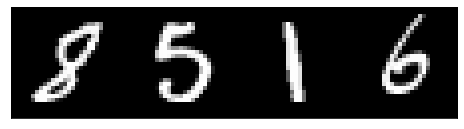


7 2 5 2 5 
torch.Size([1, 42, 512])
tensor([[[ 1.1360,  0.2139,  0.2271,  ..., -0.1285,  0.1905, -0.8327],
         [ 1.1865,  0.1861,  0.2629,  ..., -0.1334,  0.1870, -0.8434],
         [ 1.1967,  0.1317,  0.2571,  ..., -0.1319,  0.1855, -0.8484],
         ...,
         [ 1.2195,  0.1455,  0.2312,  ..., -0.0660,  0.1991, -0.7387],
         [ 1.2147,  0.1009,  0.2701,  ..., -0.0672,  0.1996, -0.7400],
         [ 1.1751,  0.0865,  0.2768,  ..., -0.0784,  0.1984, -0.7349]]],
       device='cuda:0', grad_fn=<AddBackward0>)
Original image:


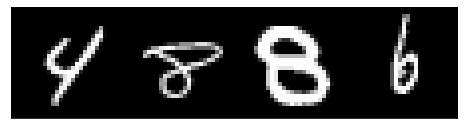


7 2 5 2 5 
torch.Size([1, 42, 512])
tensor([[[ 1.1360,  0.2139,  0.2271,  ..., -0.1285,  0.1905, -0.8327],
         [ 1.1865,  0.1861,  0.2628,  ..., -0.1334,  0.1870, -0.8434],
         [ 1.1967,  0.1317,  0.2571,  ..., -0.1319,  0.1855, -0.8484],
         ...,
         [ 1.2195,  0.1455,  0.2312,  ..., -0.0660,  0.1991, -0.7387],
         [ 1.2147,  0.1009,  0.2701,  ..., -0.0672,  0.1996, -0.7400],
         [ 1.1751,  0.0865,  0.2768,  ..., -0.0784,  0.1984, -0.7349]]],
       device='cuda:0', grad_fn=<AddBackward0>)
Original image:


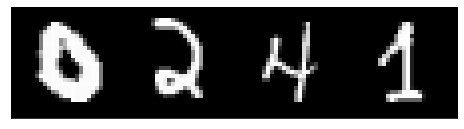


7 2 5 2 5 
torch.Size([1, 42, 512])
tensor([[[ 1.1360,  0.2139,  0.2271,  ..., -0.1285,  0.1905, -0.8327],
         [ 1.1865,  0.1861,  0.2628,  ..., -0.1333,  0.1870, -0.8435],
         [ 1.1967,  0.1317,  0.2571,  ..., -0.1318,  0.1854, -0.8484],
         ...,
         [ 1.2195,  0.1455,  0.2312,  ..., -0.0660,  0.1991, -0.7387],
         [ 1.2147,  0.1009,  0.2701,  ..., -0.0672,  0.1996, -0.7400],
         [ 1.1751,  0.0865,  0.2768,  ..., -0.0784,  0.1984, -0.7350]]],
       device='cuda:0', grad_fn=<AddBackward0>)
Original image:


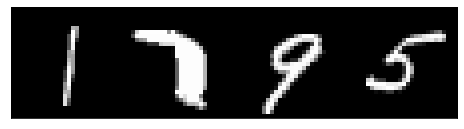


7 2 5 2 5 
torch.Size([1, 42, 512])
tensor([[[ 1.1360,  0.2139,  0.2271,  ..., -0.1285,  0.1905, -0.8327],
         [ 1.1865,  0.1861,  0.2629,  ..., -0.1334,  0.1870, -0.8434],
         [ 1.1967,  0.1317,  0.2571,  ..., -0.1319,  0.1855, -0.8483],
         ...,
         [ 1.2195,  0.1455,  0.2312,  ..., -0.0660,  0.1991, -0.7387],
         [ 1.2147,  0.1009,  0.2701,  ..., -0.0672,  0.1996, -0.7399],
         [ 1.1751,  0.0865,  0.2768,  ..., -0.0784,  0.1984, -0.7349]]],
       device='cuda:0', grad_fn=<AddBackward0>)
Original image:


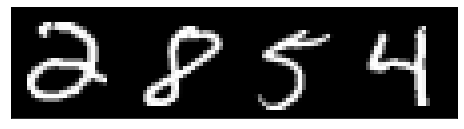


7 2 5 2 5 


In [18]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
  memory = model.encode(src, src_mask)
  print(memory.size())
  print(memory)
  ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
  for i in range(max_len-1):
    out = model.decode(memory, src_mask, Variable(ys).long(), Variable(subsequent_mask(ys.size(1))).type_as(src.data))
    prob = model.generator(out[:,-1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data[0]
    ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
  return ys

val_dataset = EquationDataset("formulas.zip", "formulas.txt", "val.txt", transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Grayscale()
  ]), file_ext='.png')

val_loader = DataLoader(val_dataset, shuffle=True, num_workers=0, batch_size=1, pin_memory=True)

for i, (src, src_mask, trg, trg_y, trg_mask) in enumerate(val_loader):
  src = src.cuda(non_blocking=True)
  out = greedy_decode(model, src, None, max_len=60, start_symbol=parser.SOS)
  print("Original image:")
  display(src)
  print()
  for i in range(1, out.size(1)):
    sym = parser.index2word[int(out[0, i].item())]
    if sym == "EOS": break
    print(sym, end=" ")
  print()

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
count_parameters(model)

20304158